<a href="https://colab.research.google.com/github/GabrielCostaDeOliveira/faceDetectionTraining/blob/main/faceDetectionDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

from fastai.vision.all import *
import numpy as np

/home/nicolas/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Definindo o `path` para o dataset.
```
join   -> concatena as strings do path
getcwd -> pega o diretório atual
ls     -> printa arquivos dentro do path
```

In [2]:
path = Path(os.path.join(os.getcwd(), '..', 'dataset'))
Path.BASE_PATH = path
path.ls()

(#3) [Path('WIDER_val'),Path('wider_face_split'),Path('WIDER_train')]

Verificando se as imagens não foram corrompidas
```
get_image_files -> pega imagens dentro do path

verify_images   -> pega imagens que não carregaram
```

In [3]:
images = get_image_files(path)
failed = verify_images(images)
failed

(#0) []

Eliminando as imagens que falharam
```
map    -> procura os elementos falhos e remove do path
unlink -> desconecta o elemento do path
```

In [4]:
failed.map(Path.unlink)

(#0) []

Definindo funções auxiliares para recuperar as anotações das imagens dado seu _path_
```

img2bbox_path         -> retorna o path das anotações

rsplit   -> separa os elementos (separador, maximoDeSeparações)

[:-4]    -> ?

get_annotation_values -> retorna as anotações

open     -> ?

f        -> ?
readlines-> ?

np.array -> ?? toda a linha ??
```

In [13]:
def img2bbox_path(path: Path):
    return 'annotations'.join(str(path).rsplit('images', 1))[:-4]

def get_annotation_values(path: Path):
    with open(img2bbox_path(path), 'r', encoding='utf-8') as f:
        return np.array([[*map(int, s.split())] for s in f.readlines()])

In [33]:
#asd = get_annotation_values(path)


Função para recuperar a bounding box de uma imagem dado seu caminho
```
any    -> pega um elemento qualquer
[:,:4] -> ?
```


In [39]:
def get_bbox(path):
    ctr = get_annotation_values(path)
    if ctr.any():
        return ctr[:,:4]
    return []

Visualizando um exemplo de imagem com sua bounding box
```
plt.imread -> le a imagem em forma de array
copy       -> gera uma copia
np.array   -> gera o array 
np.uint8   -> ?
show_image -> printa imagen
```

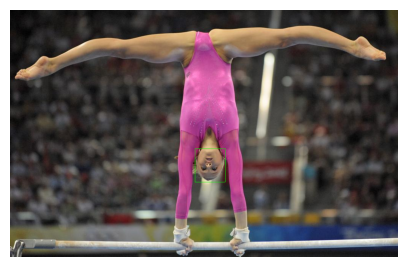

In [40]:
img = plt.imread(images[0]).copy()
for x,y,w,h in get_bbox(images[0]):
    color = np.array([0,255,0], dtype=np.uint8)
    img[y,x:x+w] = color
    img[y:y+h,x] = color
    img[y+h,x:x+w] = color
    img[y:y+h,x+w] = color
show_image(img);

A fastai espera a bounding box no formato [`left`, `top`, `right`, `bottom`].

Porém o nosso dataset utiliza no formato [`left`, `top`, `width`, `height`].

Então precisamos converter a bounding box para o formato da fastai. Para isso vamos alterar a função `get_bbox` definida anteriormente.

In [41]:
def get_bbox(path):
    ctr = get_annotation_values(path)
    if ctr.any():
        return [[x, y, x + w - 1, y + h - 1] for x, y, w, h in ctr[:,:4]]
    return []

apresentando a mesma imagem com o novo formato da bounding box

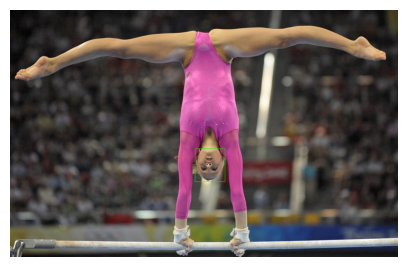

In [35]:
img = plt.imread(images[0]).copy()
for x1,y1,x2,y2 in get_bbox(images[0]):
    color = np.array([0,255,0], dtype=np.uint8)
    img[y1,x1:x2] = color
    img[y1:y2,x1] = color
    img[y2,x1:x2] = color
    img[y1:y2,x2] = color
show_image(img);

Função para recuperar os labels de uma imagem dado seu _path_
```
[:,-2] -> deixa a label do lado da bounding box
```

In [42]:
def get_label(path, lbl=['no occlusion', 'partial occlusion', 'heavy occlusion']):
    ctr = get_annotation_values(path)
    if ctr.any():
        return [lbl[x] for x in ctr[:,-2]]
    return []

Criação do DataBlock

ImageBlock   -> ?
 
BBoxBlock    -> ?

BBoxLblBlock -> ?

FuncSplitter -> ?

In [44]:
data_block = DataBlock(
    blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
    get_items=get_image_files,
    getters=[noop, get_bbox, get_label],
    splitter=FuncSplitter(lambda o: o.parent.parent.parent.name.endswith('val')),
    item_tfms=Resize(256, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
    # batch_tfms=[*aug_transforms(min_scale=1.0), Normalize.from_stats(*imagenet_stats)],
    n_inp=1
)
data_block.summary(path)

Setting-up type transforms pipelines
Found 16106 items
2 datasets of sizes 12880,3226
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_bbox -> TensorBBox.create
Setting up Pipeline: get_label -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': True}

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/nicolas/faceDetectionTraining/src/../dataset/WIDER_train/images/40--Gymnastics/40_Gymnastics_Gymnastics_40_832.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=1024x1355
  Pipeline: get_bbox -> TensorBBox.create
    starting from
      /home/nicolas/faceDetectionTraining/src/../dataset/WIDER_train/images/40--Gymnastics/40_Gymnastics_Gymnastics_40_832.jpg
    applying get_bbox gives
      [[370, 235, 570, 464]]
    applying TensorBBox.create gives
      TensorBBox of size 1x4
  Pipeline: get_label -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': True}
    starting from
      /home/nicolas/faceDetectionTraining/sr

Como podemos ver, nosso dataset é possui `12880` itens para treino e `3226` para validação.

datasets -> ?

In [45]:
datasets = data_block.datasets(path)

len(datasets.train), len(datasets.valid)

(12880, 3226)

Onde cada item é composto por uma imagem (a variável independente), uma tensor de bounding boxes e um tensor de multi categorias (que juntos compõem as variáveis dependentes).

In [54]:
datasets.train[0]

(PILImage mode=RGB size=1024x682,
 TensorBBox([[433., 189., 466., 230.],
             [ 88., 203., 140., 266.],
             [  5., 203.,  35., 235.],
             [296., 174., 340., 225.],
             [219., 166., 253., 211.],
             [900., 274., 980., 375.],
             [780., 189., 804., 223.],
             [576., 161., 615., 205.],
             [529., 180., 562., 219.]]),
 TensorMultiCategory([2, 1, 3, 1, 2, 2, 2, 1, 1]))

Cria e printa data loaders 

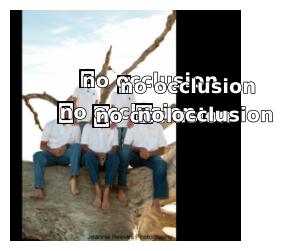

In [46]:
data_loaders = data_block.dataloaders(path, bs=6)
data_loaders.train.show_batch(max_n=1)